# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [473]:
#%%pycodestyle
from sklearn.metrics.pairwise import euclidean_distances as ED


class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random',
                 batch_size=None):

        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :init - k-means++
        :C - Координаты центроидов
        """

        self.init = init
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.centroids = None
        self.batch_size = batch_size

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        count = X.shape[0]
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(count)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        if self.init == 'random':
            self.centroids = X[np.random.choice(count,
                                                replace=False,
                                                size=self.k)]

        # Здесь мы должны инициализировать
        # центера класстеров по "умному"
        # Алгоритм:
        # Первый центройд выбираем случайным
        # образом из объектов датасета
        # Для остальных точек рассчитываем расстояние
        # Вероятность стать следующим центром класстера
        # Пропорционально расстоянию
        # -----------------
        # Как оказалась ( жаль не сразу )
        # Есть функция np.random.choice
        # Где можно указать веса рандома
        # Т.е надо всего лишь посчитать
        # Расстояния до точек
        # Для этого используем ED
        if self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0] = X[np.random.choice(count)]

            # Для всех класстеров, кроме первого,
            # Т.к он уже инициализирован
            for i in range(1, self.k):
                dist = ED(X, self.centroids[:i, :]).min(axis=1)
                dist = dist / dist.sum()
                self.centroids[i] = X[np.random.choice(X.shape[0],
                                                       replace=False,
                                                       p=dist)]

        centroids = np.empty((self.k, X.shape[1]))
        # Проводим {max_iter} итераций
        # Каждую итерацию стягиваем наши центры класстеров
        # к  более оптимальным значениям
        #: ED - евклидово расстояние
        for i in range(self.max_iter):
            X2 = X
            if self.batch_size is not None:
                X2 = X[np.random.choice(count,
                                        replace=False,
                                        size=min(self.batch_size, count))]
            # Смотрим по всем объектам
            # Какому класстеру они принадлежат
            # в данный момент
            self.labels = ED(X2, self.centroids).argmin(axis=1)
            # Проходим во всем номерам класстеров
            # Надо определить
            for i in range(self.k):
                if np.any(self.labels == i, axis=0):

                    # Считаем точки, куда мы стянем центр
                    # каждого класстера
                    centroids[i] = np.mean(X2[self.labels == i],
                                           axis=0)
                else:
                    centroids[i] = X[np.random.choice(count)]

            if np.all(np.abs(centroids - self.centroids) < 0.05):
                break

            self.centroids = centroids

        self.labels = ED(X, self.centroids).argmin(axis=1)

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        """

        return ED(X, self.centroids).argmin(axis=1)

    def __repr__(self):
        return f"MyKmeans(k={self.k}, metric='{self.metric}', \
max_iter={self.max_iter}, \
random_state={self.random_state}, init='{self.init}')"


class MiniBatchMyKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=100):
        super().__init__(k, metric, max_iter, random_state, init, batch_size)
        self.batch_size = batch_size


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [365]:
from sklearn.datasets import make_blobs

In [366]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

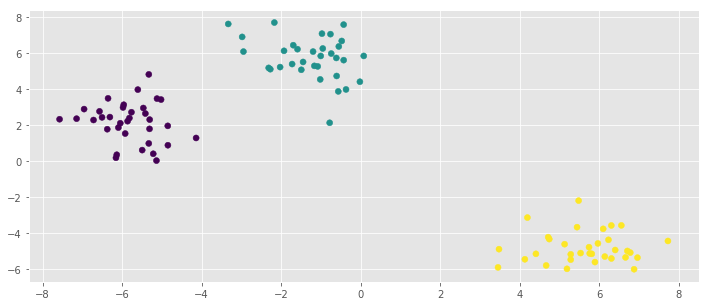

In [367]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

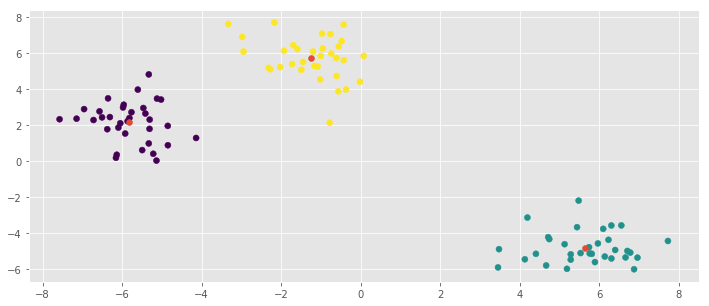

In [370]:
## Работоспособность MyKmeans
clf = MyKmeans(k=3)
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

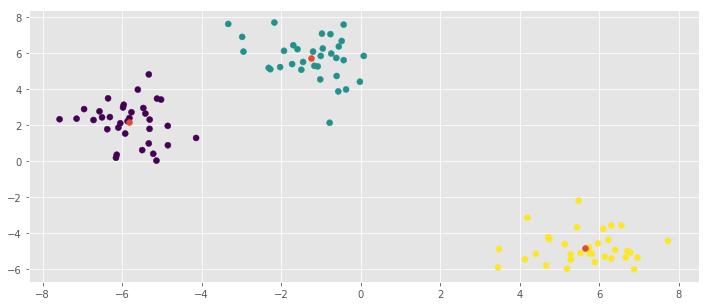

In [371]:
## Работоспособность MyKmeans++
clf = MyKmeans(k=3, init='k-means')
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

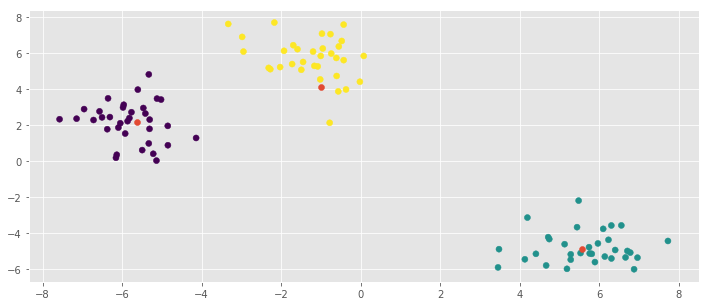

In [372]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
clf = MiniBatchMyKMeans(k=3, batch_size=10)
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

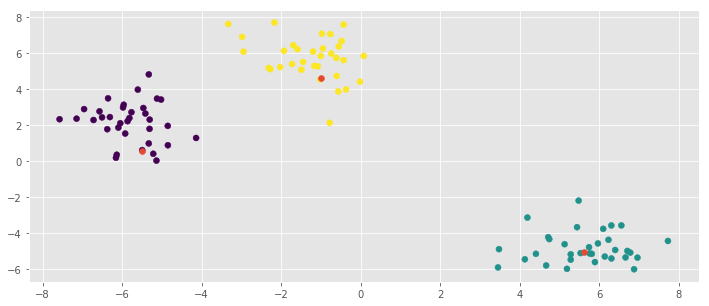

In [373]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchMyKMeans(k=3, init='k-means', batch_size=10)
clf.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X))
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1])

По честному ставим n_init=1 в оригинальном KMeans

In [475]:
clf = KMeans(n_clusters=3, init='random', max_iter=1000, n_init=1)
clf2 = MyKmeans(k=3, init='random', max_iter=1000)
clf3 = MyKmeans(k=3, init='k-means', max_iter=1000)
clf4 = MiniBatchMyKMeans(k=3, batch_size=10)
clf5 = MiniBatchMyKMeans(k=3, init='k-means', batch_size=10)

In [379]:
## Время выполнения алгоритма Kmeans из sklearn
%time clf.fit(X)

CPU times: user 4.71 ms, sys: 0 ns, total: 4.71 ms
Wall time: 10.5 ms


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
    n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [380]:
## Время выполнения алгоритма MyKmeans
%time clf2.fit(X)

CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 8.17 ms


MyKmeans(k=3, metric='euclidean', max_iter=1000, random_state=None, init='random')

In [381]:
## Время выполнения алгоритма MyKmeans++
%time clf3.fit(X)

CPU times: user 4.57 ms, sys: 0 ns, total: 4.57 ms
Wall time: 9.41 ms


MyKmeans(k=3, metric='euclidean', max_iter=1000, random_state=None, init='k-means')

In [382]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
%time clf4.fit(X)

CPU times: user 475 µs, sys: 3.15 ms, total: 3.62 ms
Wall time: 9.07 ms


MyKmeans(k=3, metric='euclidean', max_iter=1000, random_state=None, init='random')

In [383]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
%time clf5.fit(X)

CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 9.31 ms


MyKmeans(k=3, metric='euclidean', max_iter=1000, random_state=None, init='k-means')

# Задание 4

In [384]:
from time import time

In [385]:
samples = np.linspace(100, 100000, 10, dtype=int)

In [386]:
samples.shape[0]

10

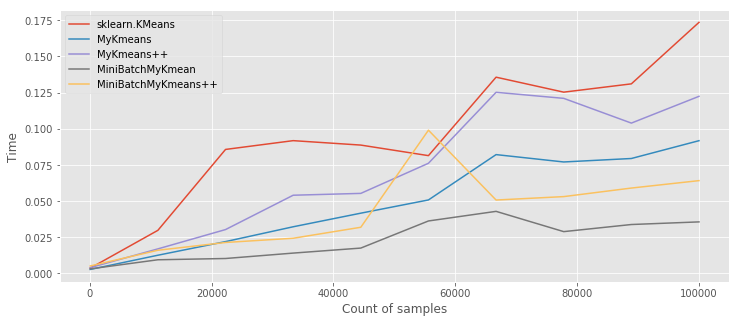

In [481]:
info = np.empty((5, samples.shape[0]))
names = ['sklearn.KMeans', 'MyKmeans', 'MyKmeans++', 'MiniBatchMyKmean', 'MiniBatchMyKmeans++']

for j, size in enumerate(samples):
    X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

    for i, model in enumerate([clf, clf2, clf3, clf4, clf5]):
        t0 = time()
        model.fit(X)
        info[i][j] = time() - t0

for i in range(5):
    plt.plot(samples, info[i], label=names[i])

plt.xlabel('Count of samples')
plt.ylabel('Time')
plt.legend()

Прям как я и ожидал

Мини матчи самый быстрые, потом обычные

Причем в группировки по флагу есть батч или нет, метод с ++ работает медленнее

Оно и понятно, так и должно быть

И оригинальный Kmeans самый медленный, потому то так было сказано в задании))

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [390]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [409]:
df = df_sns.drop(labels=['gradyear', 'gender', 'age', 'friends'], axis=1)
df = (df - df.mean()) / df.std()
X = df.values

In [410]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50)

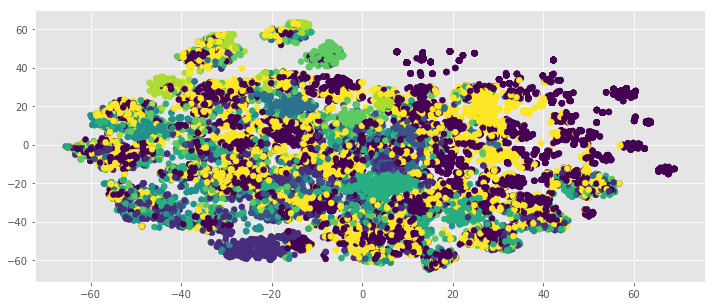

In [411]:
## MyKMeans
clf = MyKmeans(k=9)
clf.fit(X)
df['c'] = clf.labels

T = tsne.fit_transform(X)
plt.scatter(T[:, 0], T[:, 1], c=clf.labels)

In [418]:
clf = MyKmeans(k=9)
clf.fit(X)
df['c'] = clf.labels

for i in range(9):
    print(f'-------- Number of cluster = {i} --------')
    print(df[df['c'] == i].mean().T.sort_values(ascending=False))

-------- Number of cluster = 0 --------
dress           2.799863
shopping        1.644970
hair            1.109586
clothes         1.025136
die             1.009508
kissed          0.938821
mall            0.868314
cute            0.792161
drugs           0.696971
sex             0.691852
band            0.671497
dance           0.525409
drunk           0.510857
music           0.447384
rock            0.414951
marching        0.406412
church          0.370436
sexy            0.270418
swimming        0.263710
cheerleading    0.247556
death           0.213193
blonde          0.211726
god             0.190690
sports          0.174610
hot             0.148944
abercrombie     0.144453
volleyball      0.127256
soccer          0.094099
hollister       0.091859
softball        0.086726
football        0.072728
basketball      0.071321
bible           0.056344
jesus           0.050817
tennis          0.017237
baseball        0.013341
c               0.000000
dtype: float64
-------- Number of c

In [419]:
## MyKMeans++
clf = MyKmeans(k=9, init='k-means')
clf.fit(X)
df['c'] = clf.labels

for i in range(9):
    print(f'-------- Number of cluster = {i} --------')
    print(df[df['c'] == i].mean().T.sort_values(ascending=False))

-------- Number of cluster = 0 --------
sports          3.603274
basketball      1.786563
baseball        1.021029
football        0.964528
softball        0.862329
volleyball      0.761832
soccer          0.646040
music           0.181515
tennis          0.170311
clothes         0.140416
hair            0.130292
death           0.100098
swimming        0.092741
god             0.079875
church          0.046412
dance           0.039893
shopping        0.035381
blonde          0.033975
sexy            0.031722
abercrombie     0.020547
rock            0.016913
drunk           0.015308
band            0.012504
cheerleading    0.009459
bible           0.009262
drugs           0.003250
c               0.000000
hollister      -0.000520
mall           -0.011005
sex            -0.017877
jesus          -0.026933
die            -0.026985
marching       -0.032189
dress          -0.032412
hot            -0.036366
kissed         -0.052117
cute           -0.072352
dtype: float64
-------- Number of c

In [441]:
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchMyKMeans(k=9, batch_size=100)
clf.fit(X)

df['c'] = clf.labels

for i in range(9):
    print(f'-------- Number of cluster = {i} --------')
    print(df[df['c'] == i].mean().T.sort_values(ascending=False))

-------- Number of cluster = 0 --------
basketball      2.354083
swimming        2.010544
shopping        1.339560
soccer          0.714915
volleyball      0.559115
softball        0.449175
cute            0.376809
music           0.360826
church          0.341168
clothes         0.326472
mall            0.296346
sports          0.286150
rock            0.195424
drunk           0.182352
football        0.166998
hair            0.112234
kissed          0.109315
baseball        0.089067
dance           0.086074
hot             0.082971
tennis          0.082353
band            0.071362
god             0.065492
blonde          0.041448
sexy            0.017545
dress           0.015109
c               0.000000
death          -0.002631
marching       -0.007950
bible          -0.017476
die            -0.019435
sex            -0.020844
hollister      -0.028991
jesus          -0.033596
drugs          -0.042368
abercrombie    -0.042619
cheerleading   -0.098299
dtype: float64
-------- Number of c

In [442]:
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchMyKMeans(k=9, init='k-means', batch_size=100)
clf.fit(X)

df['c'] = clf.labels

for i in range(9):
    print(f'-------- Number of cluster = {i} --------')
    print(df[df['c'] == i].mean().T.sort_values(ascending=False))

-------- Number of cluster = 0 --------
shopping        0.440778
music           0.280048
dress           0.277651
swimming        0.268999
cute            0.231322
clothes         0.201500
mall            0.201338
church          0.197254
god             0.196529
band            0.195405
jesus           0.170031
cheerleading    0.164330
rock            0.153937
hair            0.150554
hot             0.150240
volleyball      0.143727
marching        0.123890
dance           0.116585
tennis          0.107988
death           0.107190
hollister       0.104175
softball        0.099174
basketball      0.092927
abercrombie     0.092058
die             0.089468
sports          0.067165
bible           0.064811
sexy            0.048184
kissed          0.016473
blonde          0.004249
c               0.000000
sex            -0.008318
drunk          -0.019675
football       -0.065612
drugs          -0.073182
baseball       -0.086796
soccer         -0.125612
dtype: float64
-------- Number of c

## Вывод

Стоить рассмотреть две отдельные группы:

1) Без батчей

2) С батчами

Вторая группа ( с батчами ) проигрывает первой по точности, но сильно выигрывает по времени работы. 

Теперь в каждой группе надо расстротреть разницу обычного и ++ алгоритма

KMeans++ лучшая ( самая точная ) реализация KMeans. И с лучшей инициализацией, которая редко допускает чтобы точки лежали слишком близко.

Запустим Kmeans++ раз 10, и выбрать лучшее - вот алгоритм лучшей кластеризации.

MiniBatchKmeans - быстро, но хуже, хотя мы можем регулировать размер батча, и на огромных данных, можно взять относительно маленький размер и получить +- хороший результат.

MiniBatchKmeans++ - лучше обычного, больше сказать нечего.

# Общий вывод:

Kmeans - это круто, очень быстрый, простой в понимании и реализации алгоритм.

Прогоняя его много раз, мы можем получать лучшие результаты, т.к k-means находит не глобально лучший результат, а лишь лучший результат для такого выбора начальных точек.

Я считаю, что как базовый алгоритм для простых кластеризованных структур лучше, чем KMeans не придумаешь.